# Check data

In [23]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
import datetime
import numpy as np
from suncalc import get_position, get_times
from tueplots import bundles
from tueplots.constants.color import rgb

import warnings
warnings.simplefilter('ignore')

from utils import get_dataframe
from plot_config import config

## Load data

In [24]:
years = [2019, 2020, 2021, 2022]
months = months = ["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
kWhp_system = 0.31 * 22

# load data and interpolated data
data = get_dataframe()
data_interpolated = get_dataframe(interpolate_data=True)

# add column for year, month and day of the year
# convert "Datum und Uhrzeit" column to date
data["Date"] = [datetime.datetime.strptime(data["Datum und Uhrzeit"][i], "%d.%m.%Y") for i in range(len(data))]
data["Year"] = data["Date"].dt.year
data_interpolated["Year"] = data["Date"].dt.year
data["Day of year"] = data["Date"].dt.dayofyear
data_interpolated["Day of year"] = data["Date"].dt.dayofyear
data["Month"] = data["Date"].dt.month
data_interpolated["Month"] = data["Date"].dt.month
# drop date
data = data.drop("Date", axis=1)

data.head()

,Datum und Uhrzeit,Gesamtanlage[kWh],FX,FM,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,Year,Day of year,Month
0,01.01.2019,1.71013,15.2,4.8,1.6,8,0.0,0,7.9,7.1,965.6,4.1,87.0,5.2,2.7,1.9,2019,1,1
1,02.01.2019,0.02722,17.0,6.0,0.6,8,0.7,0,7.0,5.0,965.5,0.4,78.0,3.2,-2.1,-4.8,2019,2,1
2,03.01.2019,0.49862,10.1,4.1,0.0,8,2.9,0,7.4,3.9,971.2,-1.9,73.0,-0.6,-3.1,-4.4,2019,3,1
3,04.01.2019,0.00908,12.1,4.2,5.0,8,0.0,0,7.7,4.8,970.3,-1.1,85.0,-0.3,-1.7,-2.2,2019,4,1
4,05.01.2019,0.00005,16.1,6.5,22.1,8,0.0,5,7.6,5.9,963.8,0.0,96.0,1.0,-0.9,-0.8,2019,5,1


## Compare estimated production with actual production

[PVGIS](https://re.jrc.ec.europa.eu/pvg_tools/en/) provides estimated monthly and annual production for a PV system at a given location (48.100,11.140), angle (10°) and azimuth (-110°). The installed peak PV power [kWp] can be calculated by multiplying the peak power per module (0.31 kW) by the number of modules (22).

You also need to estimate system losses (due to cables, inverters, dirt, etc.). First, we used the PVGIS default of 14%.

In [25]:
# yearly production estimated by pvgis
estimated_yearly_production = 5906.84
estimated_yearly_variability = 295.04

# actual production
yearly_production = data.groupby(by="Year").sum()["Gesamtanlage[kWh]"]
print(yearly_production)
print("")
print("Production within the estimate: ")
(yearly_production <= estimated_yearly_production + estimated_yearly_variability) \
& (yearly_production >= estimated_yearly_production - estimated_yearly_variability)

Year
2019    6380.69066
2020    6295.46081
2021    5851.32172
2022    6641.21226
Name: Gesamtanlage[kWh], dtype: float64

Production within the estimate: 


Year
2019    False
2020    False
2021     True
2022    False
Name: Gesamtanlage[kWh], dtype: bool

It does not seem plausible that actual production was higher than the estimate in all but one year. The assumed system losses are probably not correct. \
Solution: The data do not represent the energy delivered to the grid, but the energy measured at the inverters. Therefore, inverter losses are not visible in the data, but PVGIS models inverter losses. We overestimated the losses and need to reduce the estimated system losses for our data. The manufacturer declares a maximum efficiency of 99% for the inverters. We then used 11% as an input for system losses. (Note that this is a sanity check to make sure we are aware of the important characteristics of the data. So it's okay to have only a rough estimate of system losses.)

In [26]:
# yearly production estimated by pvgis (11% sytem losses)
estimated_yearly_production = 6112.89
estimated_yearly_variability = 295.04

# actual production
yearly_production = data.groupby(by="Year").sum()["Gesamtanlage[kWh]"]
print(yearly_production)
print("")
print("Production within the estimate: ")
(yearly_production <= estimated_yearly_production + estimated_yearly_variability) \
& (yearly_production >= estimated_yearly_production - estimated_yearly_variability)

Year
2019    6380.69066
2020    6295.46081
2021    5851.32172
2022    6641.21226
Name: Gesamtanlage[kWh], dtype: float64

Production within the estimate: 


Year
2019     True
2020     True
2021     True
2022    False
Name: Gesamtanlage[kWh], dtype: bool

In 2022, more energy production was achieved than estimated. But there was also more sun than usual in 2022 ([DWD](https://www.dwd.de/DE/wetter/thema_des_tages/2023/1/14.html)). PVGIS uses some averaged weather conditions for its estimations. So this is still plausible.

In [27]:
print("Hours of sunshine in each year:")
print(data.groupby(by="Year").sum()["SDK"])

Hours of sunshine in each year:
Year
2019    2016.800
2020    2150.900
2021    1998.481
2022    2279.144
Name: SDK, dtype: float64


In [28]:
# PVGIS estimates of solar electricity generation [kWh]
estimated_data = {"Jan": 155.6, "Feb": 259.4, "Mar": 494.2, "Apr": 709.4, "May": 806.6, "Jun": 862.1, 
                  "Jul": 887.8, "Aug": 751.8, "Sep": 537.0, "Oct": 341.4, "Nov": 178.8, "Dec": 128.8}
estimates = pd.DataFrame.from_dict(estimated_data, orient="index", columns=["Gesamtanlage[kWh]"])
estimates["Month"] = np.arange(1, 13)

# actual production per month
monthly_production = data.groupby(by=["Year", "Month"])["Gesamtanlage[kWh]"].sum().reset_index()

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


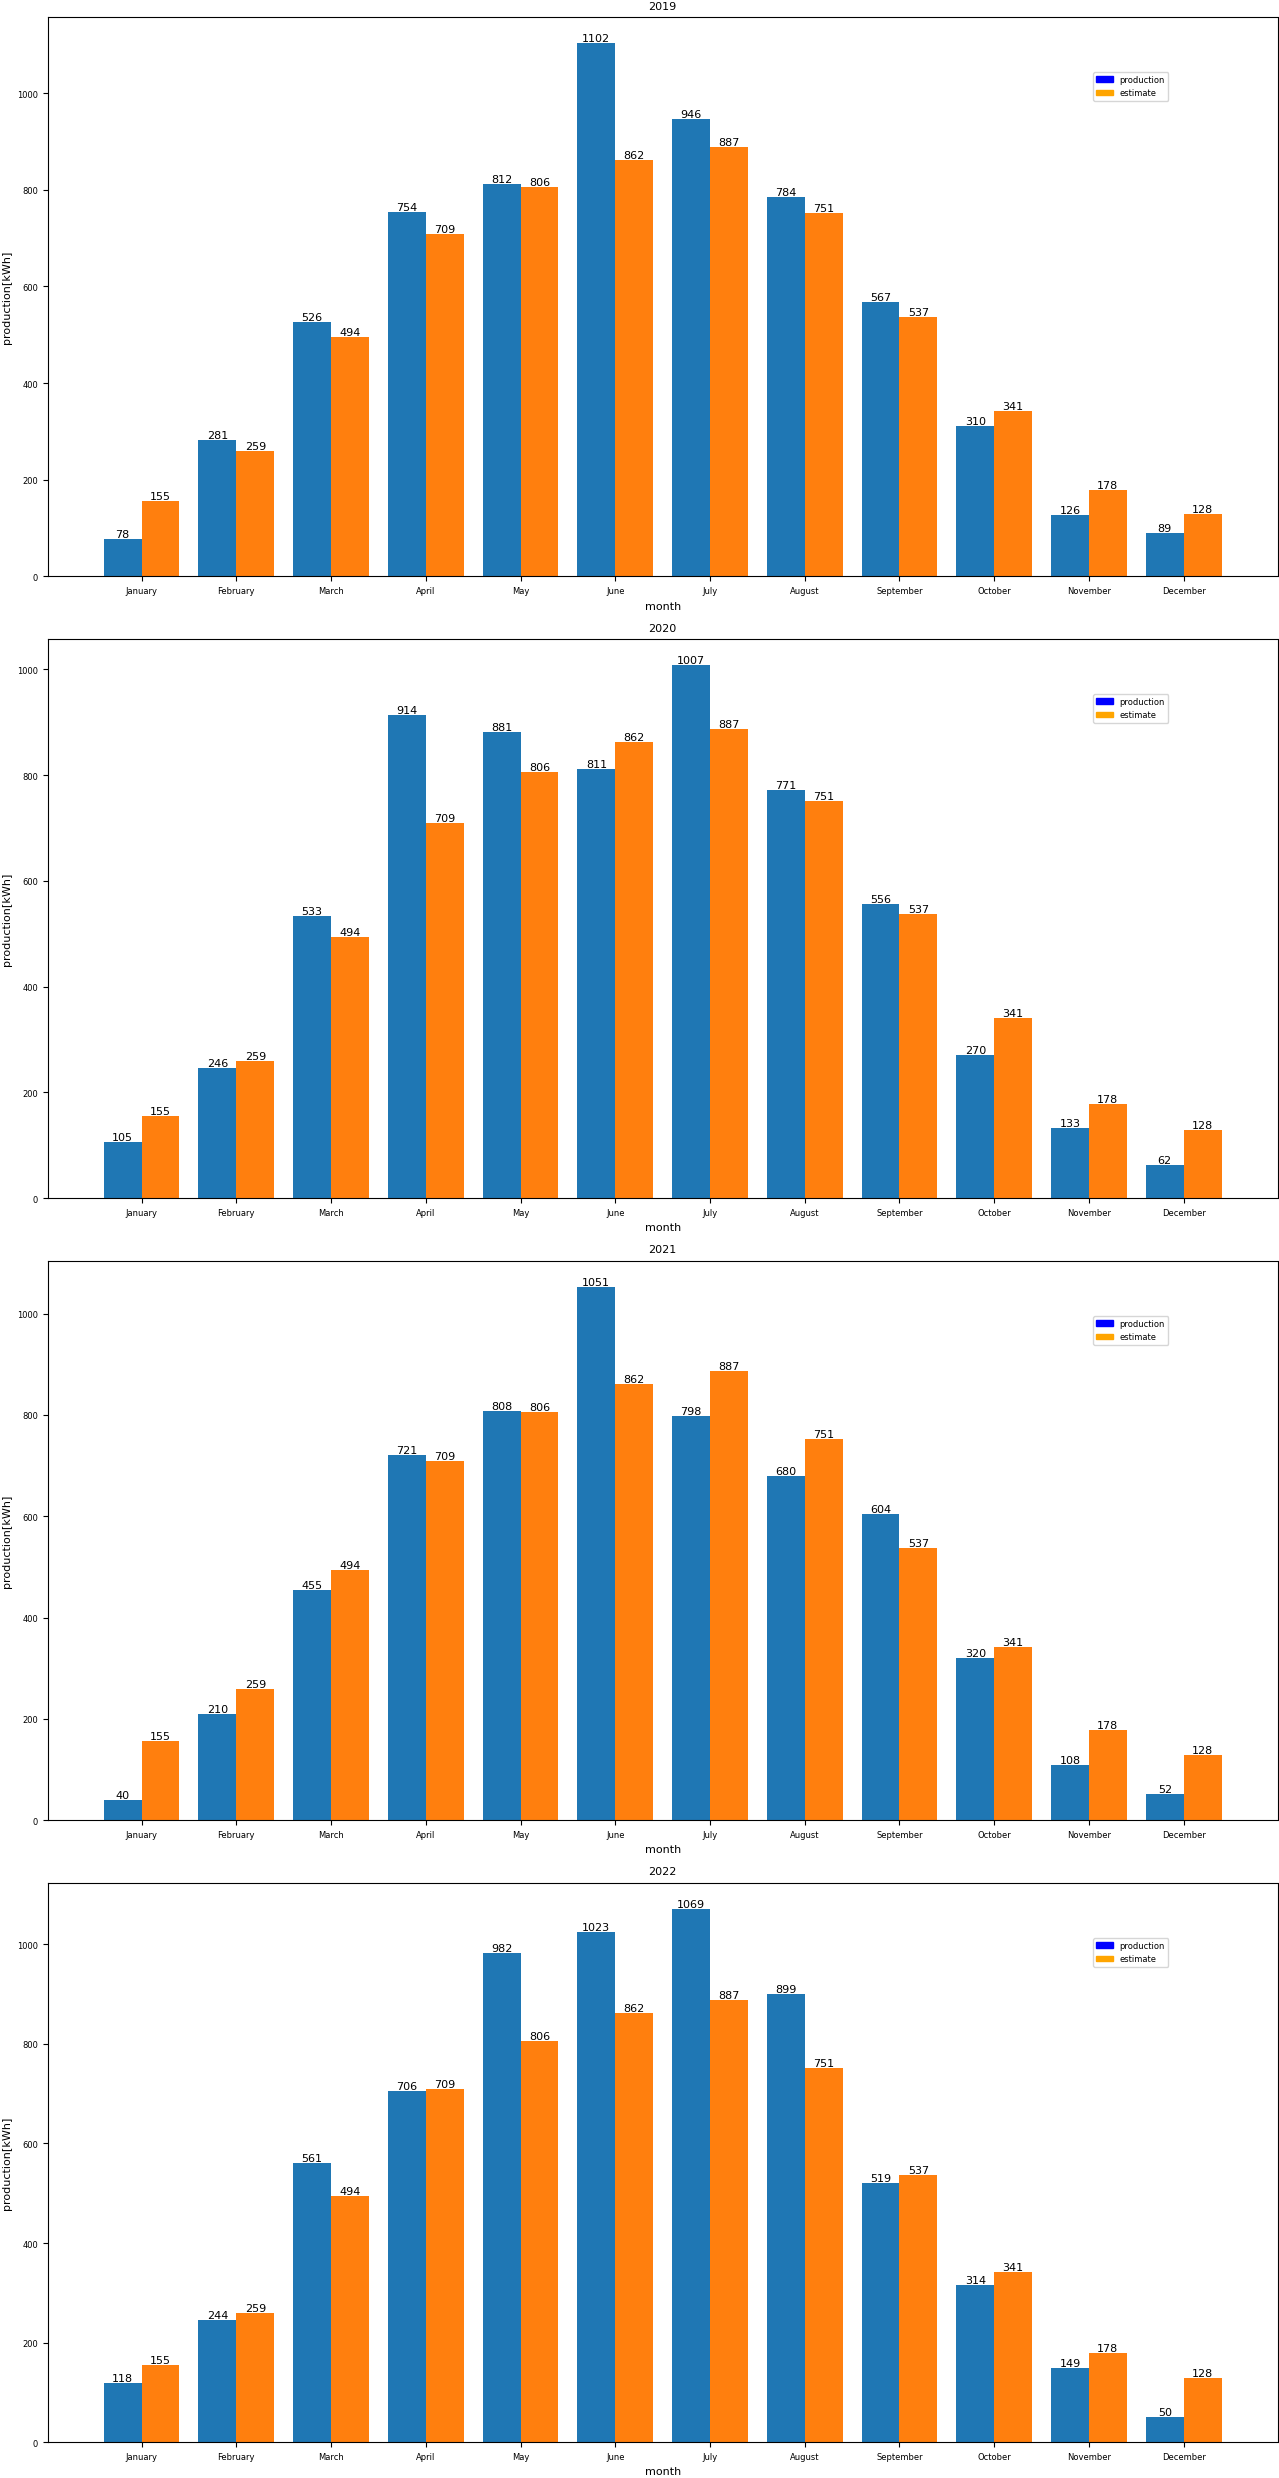

In [29]:
fig, axes = plt.subplots(4, 1, figsize=(13,25), sharey=False)
i = 0
for year in years:
    ax = axes.flatten()[i]
    year_data = monthly_production[monthly_production["Year"] == year]
    ax.bar(year_data["Month"]-0.2, year_data["Gesamtanlage[kWh]"], width=0.4)
    ax.bar(estimates["Month"]+0.2, estimates["Gesamtanlage[kWh]"], width=0.4)
    ax.set_xticks(np.arange(1, 13))
    ax.set_xticklabels(months)
    ax.set_xlabel("month")
    ax.set_ylabel("production[kWh]")
    ax.set_title(year)

    # legend
    colors = {'production': 'blue', 'estimate': 'orange'}
    patch = [mpatches.Patch(color=color, label=label) for (label, color) in colors.items()]
    ax.legend(handles=patch, loc=(0.85, 0.85))

    for bars in ax.containers:
        ax.bar_label(bars, fmt='%d') 


    i += 1


plt.tight_layout()
plt.show()

In summer (especially in June) the production is higher than estimated. However, it is plausible because there are variations between years, and recent years may have had better weather conditions than the estimated average used by pvgis. In December, there is much less production than estimated. One explanation could be that there was snow on the system that prevented any production and was not modeled in pvgis.

## Look at production per hour

ACHTUNG: The total production of the system is divided by the hours of sunshine. This assumes that there is no energy production when there is no sun. However: PV modules can produce energy even when the sun is covered by clouds.

In [30]:
# production of one module per hour of sunshine for each day
prod_per_hour_per_module = np.divide(data["Gesamtanlage[kWh]"], data["SDK"], out=np.zeros_like(data["Gesamtanlage[kWh]"]), where=data["SDK"]!=0) / 22
prod_per_hour_per_module_interpolated = np.divide(data_interpolated["Gesamtanlage[kWh]"], data_interpolated["SDK"], 
                                                  out=np.zeros_like(data_interpolated["Gesamtanlage[kWh]"]), where=data_interpolated["SDK"]!=0) / 22
data["production per hour per module"] = prod_per_hour_per_module
data_interpolated["production per hour per module"] = prod_per_hour_per_module_interpolated
print("Maximum production per module and solar hour under optimum test conditions according to the manufacturer: 0.31 kWh")
print("Mean production per hour: " + str(np.round(prod_per_hour_per_module.mean(), 2)) + " kWh - interpolated: " 
      + str(np.round(prod_per_hour_per_module_interpolated.mean(), 2)) + " kWh")
print("Median production per hour: " + str(np.round(prod_per_hour_per_module.median(), 2)) + " kWh - interpolated: " 
      + str(np.round(prod_per_hour_per_module_interpolated.median(), 2)) + " kWh")
print("Maximum production per hour: " + str(np.round(prod_per_hour_per_module.max(), 2)) + " kWh - interpolated: " 
      + str(np.round(prod_per_hour_per_module_interpolated.max(), 2)) + " kWh")
print("Standard deviation: " + str(np.round(prod_per_hour_per_module.std(), 2)) + " - interpolated: " 
      + str(np.round(prod_per_hour_per_module_interpolated.std(), 2)))

Maximum production per module and solar hour under optimum test conditions according to the manufacturer: 0.31 kWh
Mean production per hour: 0.37 kWh - interpolated: 0.44 kWh
Median production per hour: 0.13 kWh - interpolated: 0.13 kWh
Maximum production per hour: 38.18 kWh - interpolated: 39.92 kWh
Standard deviation: 1.58 - interpolated: 1.85


Producing more than 0.31 kWh per hour per module is unrealistic. (Maybe are values are due to wrong sun shine data (there is more sun at the location were the module is located than reported at the weather station some kilometers away))

In [31]:
# look closer at outlier days and realistic days alone
print("How many days are unrealistic? (production is greater 0.31 kWh)")
outlier_days = data[data["production per hour per module"]>0.31]
outlier_days_interpolated = data_interpolated[data_interpolated["production per hour per module"]>0.31]
print(str(len(outlier_days)) + " of " + str(len(data)) + " days in total in the data set")
print("For the interpolated hours of sunshine:")
print(str(len(outlier_days_interpolated)) + " of " + str(len(data)) + " days in total in the data set")
print()
print("Mean production per hour for outlier days: " + str(np.round(outlier_days["production per hour per module"].mean(), 2)) +
      " kWh - interpolated: " + str(np.round(outlier_days_interpolated["production per hour per module"].mean(), 2)) + " kWh")
print("Standard deviation for outlier days: " + str(np.round(outlier_days["production per hour per module"].std(), 2)) +
      " kWh - interpolated: " + str(np.round(outlier_days_interpolated["production per hour per module"].std(), 2)) + " kWh")
print("Minium production per hour for outlier days: " + str(np.round(outlier_days["production per hour per module"].min(), 5)) +
      " kWh - interpolated: " + str(np.round(outlier_days_interpolated["production per hour per module"].min(), 5)) + " kWh")
realistic_days = data[data["production per hour per module"]<=0.31]
realistic_days_interpolated = data_interpolated[data_interpolated["production per hour per module"]<=0.31]
print("Mean production per hour for realistic days only: " + str(np.round(realistic_days["production per hour per module"].mean(), 2)) +
      " kWh - interpolated: " + str(np.round(realistic_days_interpolated["production per hour per module"].mean(), 2)) + " kWh")
print("Standard deviation for realistic days only: " + str(np.round(realistic_days["production per hour per module"].std(), 2)) +
      " kWh - interpolated: " + str(np.round(realistic_days_interpolated["production per hour per module"].std(), 2)) + " kWh")
print("Maximum production per hour for realistic days only: " + str(np.round(realistic_days["production per hour per module"].max(), 2)) +
      " kWh - interpolated: " + str(np.round(realistic_days_interpolated["production per hour per module"].max(), 2)) + " kWh")

How many days are unrealistic? (production is greater 0.31 kWh)
230 of 1461 days in total in the data set
For the interpolated hours of sunshine:
237 of 1461 days in total in the data set

Mean production per hour for outlier days: 1.77 kWh - interpolated: 2.12 kWh
Standard deviation for outlier days: 3.69 kWh - interpolated: 4.21 kWh
Minium production per hour for outlier days: 0.31001 kWh - interpolated: 0.31002 kWh
Mean production per hour for realistic days only: 0.11 kWh - interpolated: 0.12 kWh
Standard deviation for realistic days only: 0.07 kWh - interpolated: 0.08 kWh
Maximum production per hour for realistic days only: 0.31 kWh - interpolated: 0.31 kWh


2019


findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


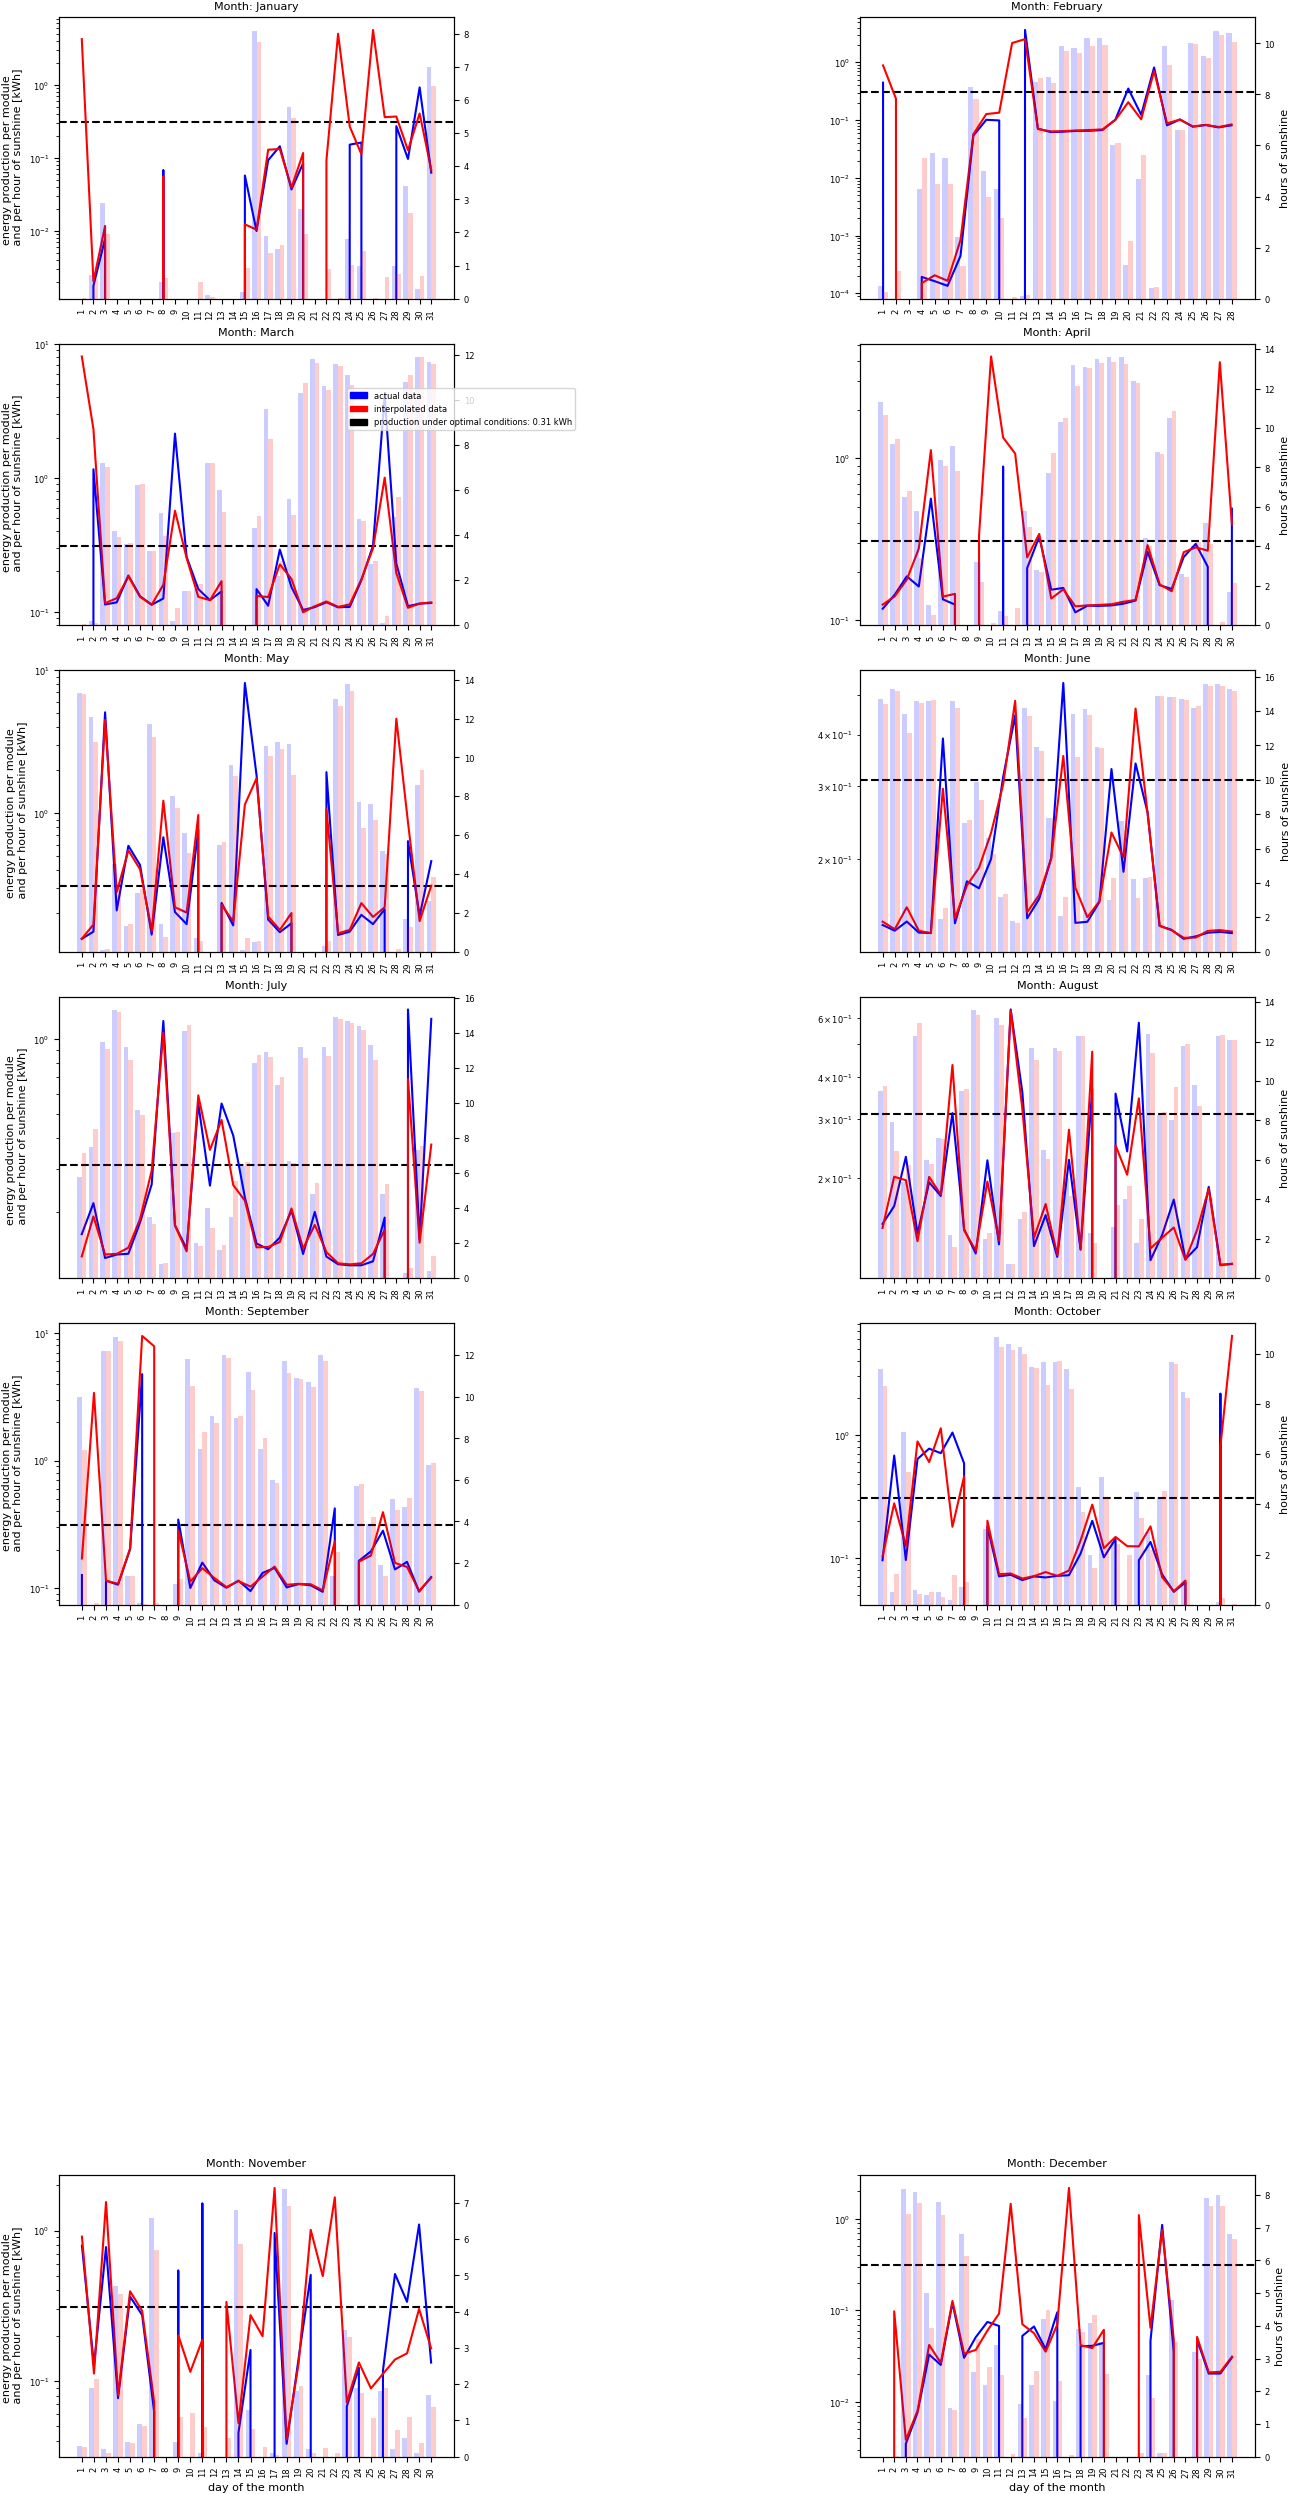

2020


findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


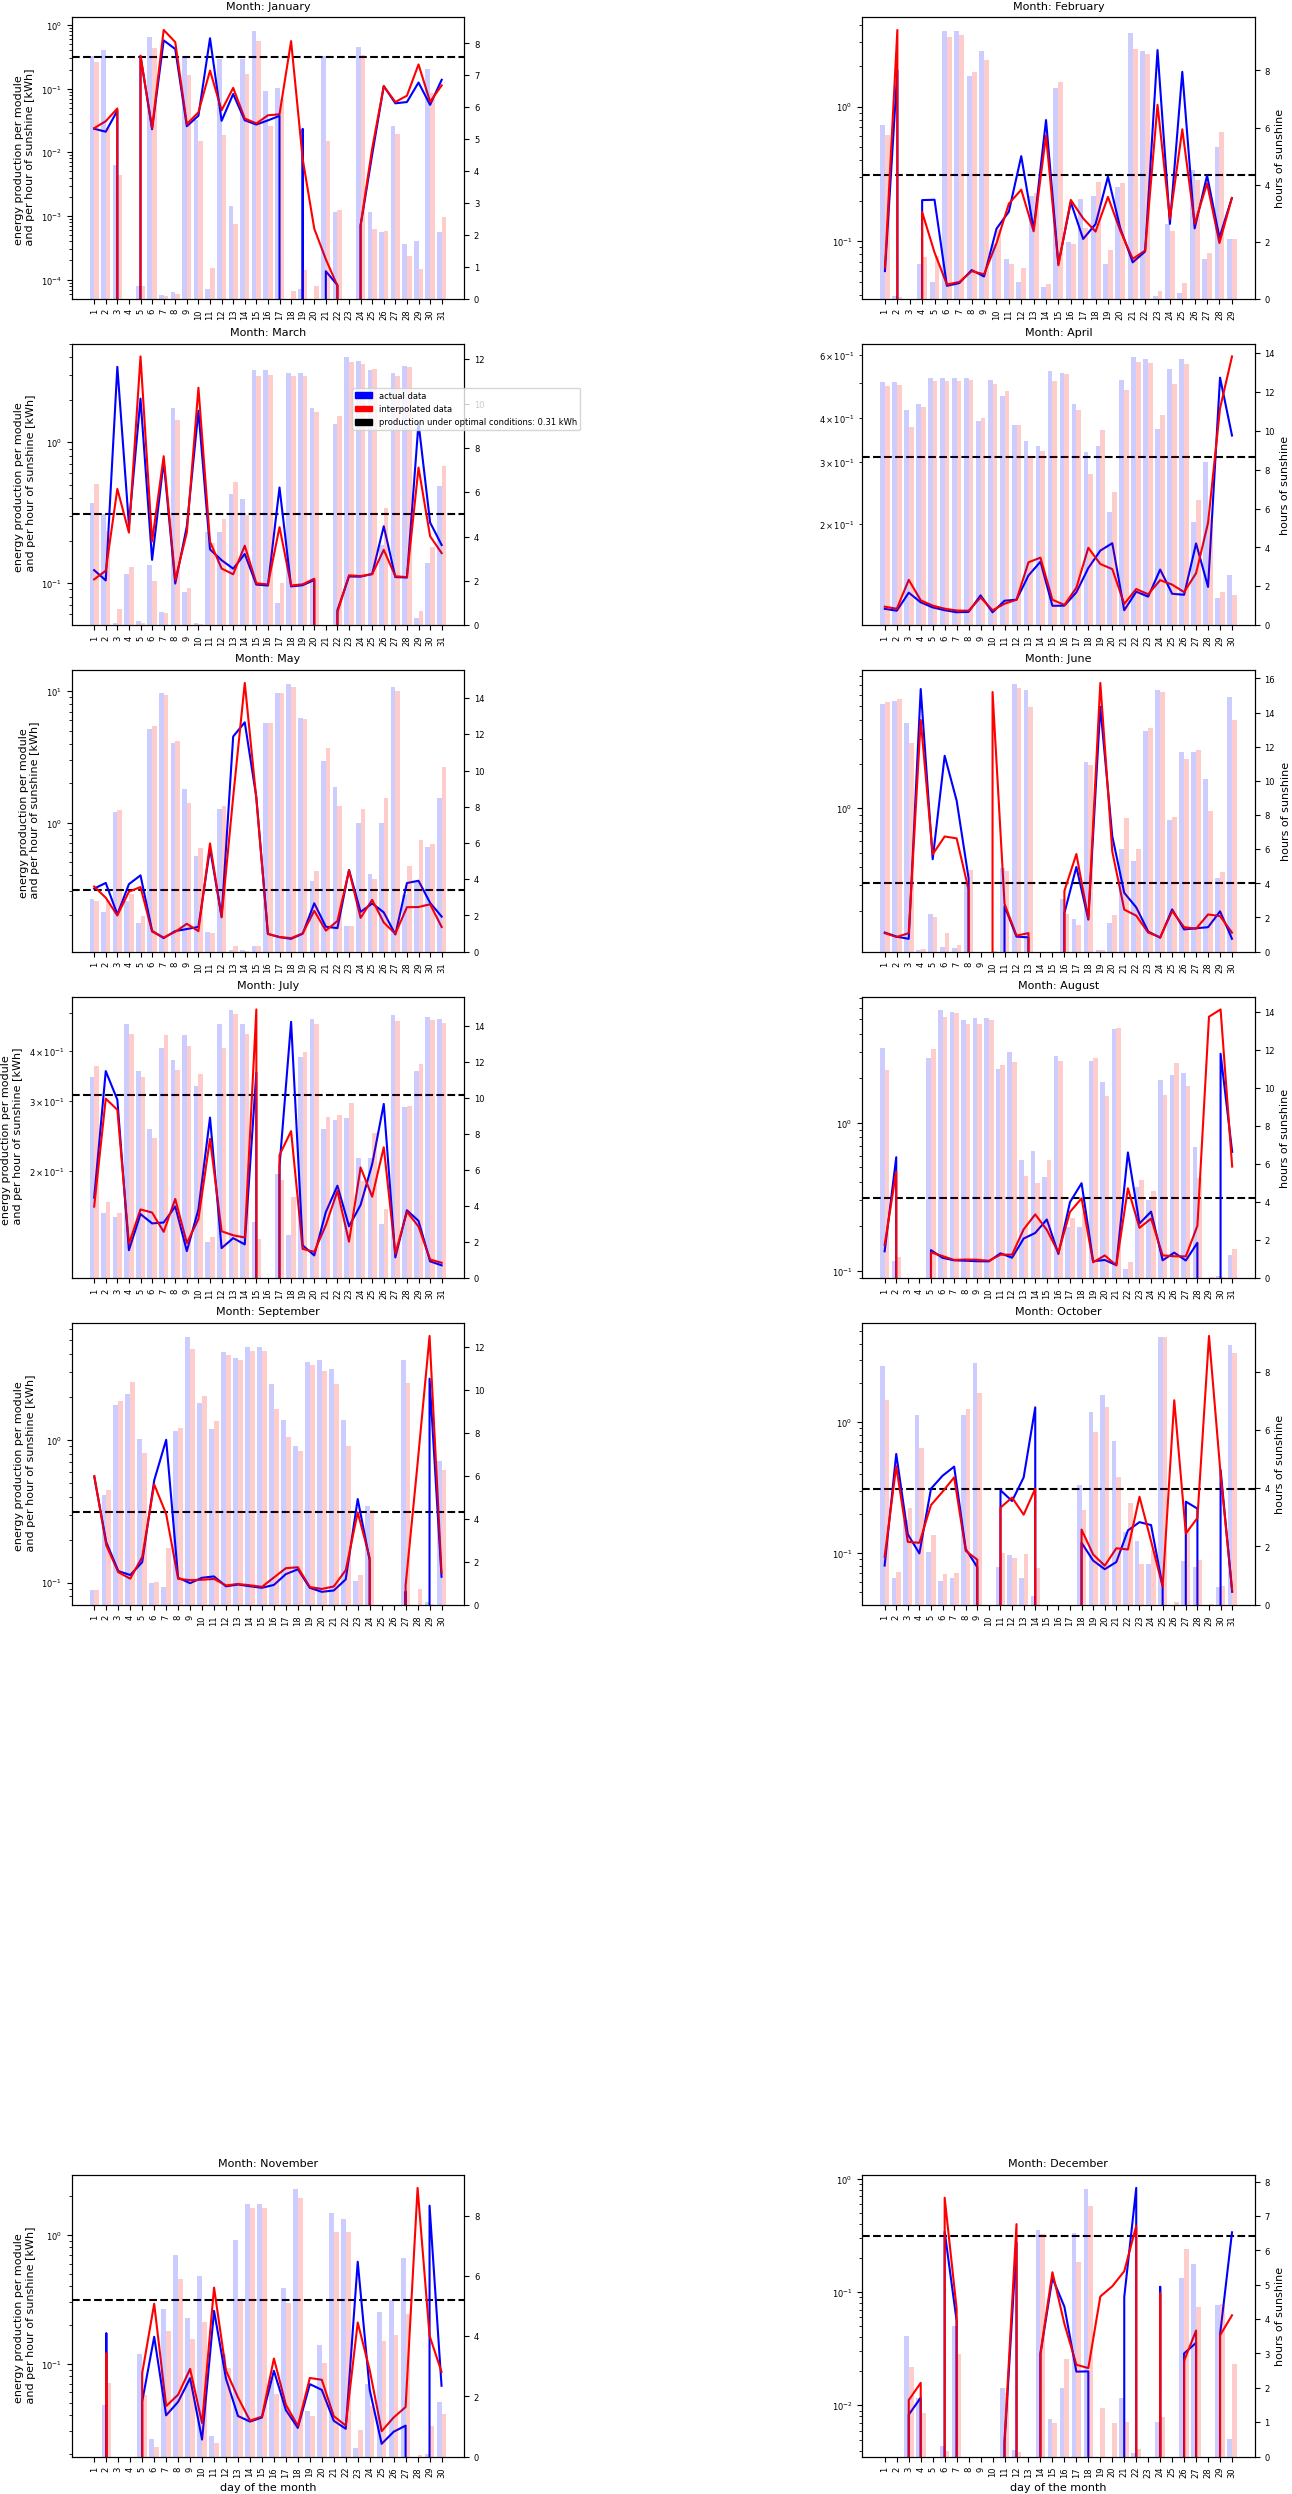

2021


findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


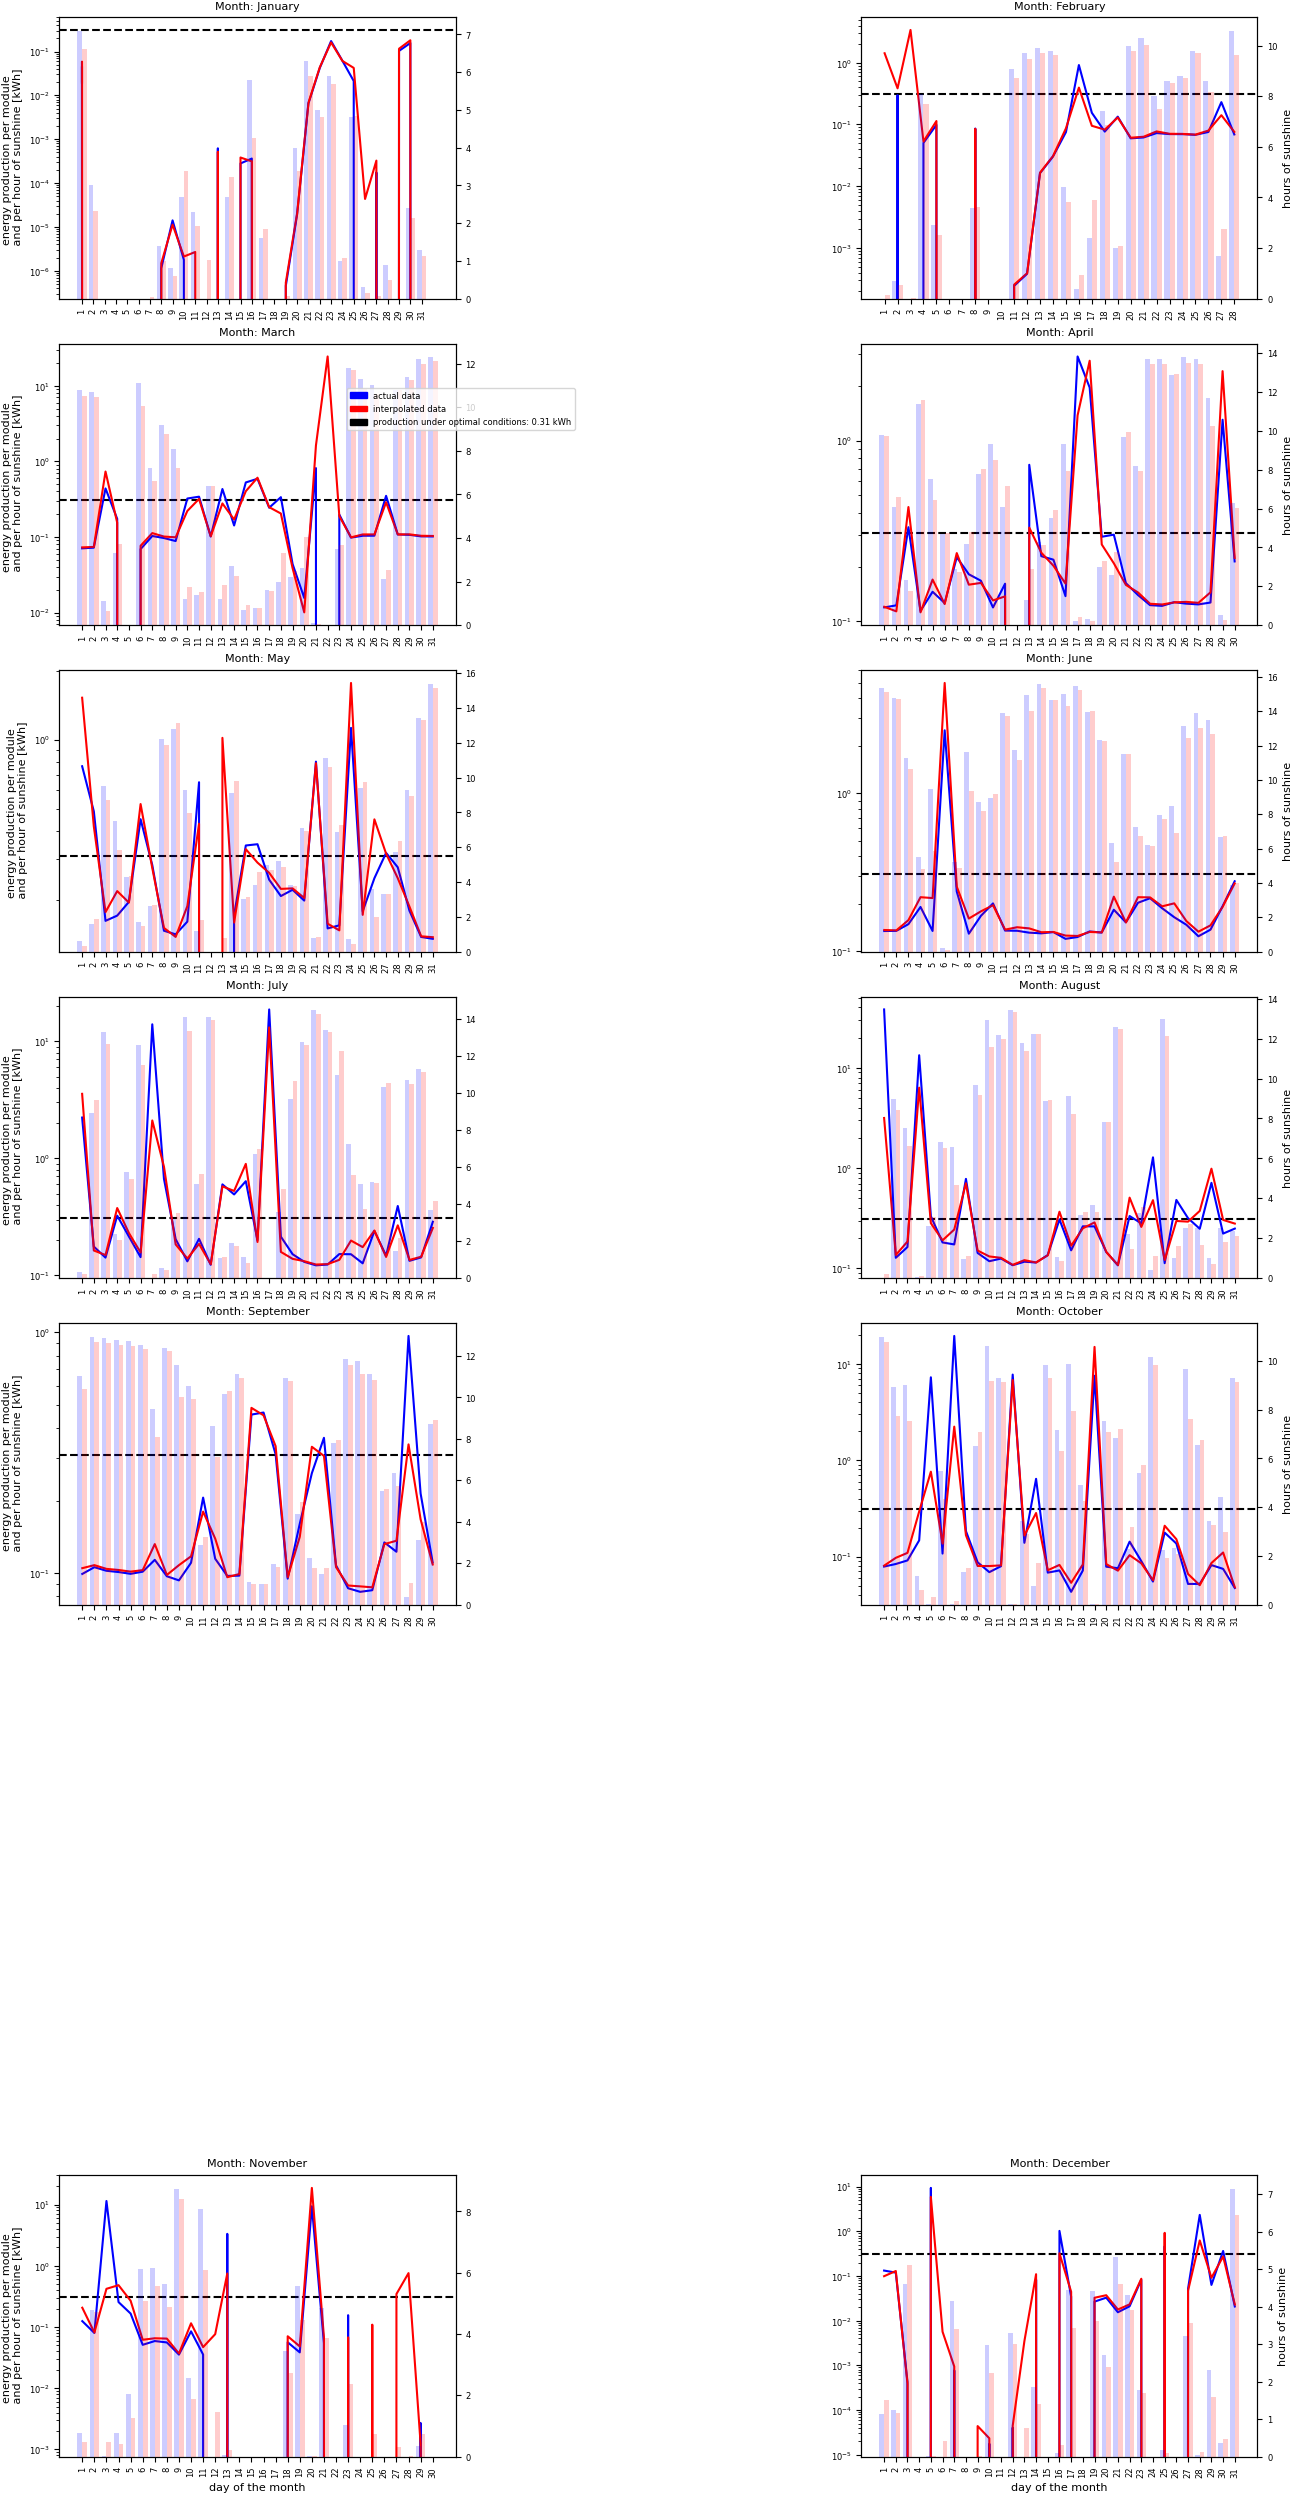

2022


findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


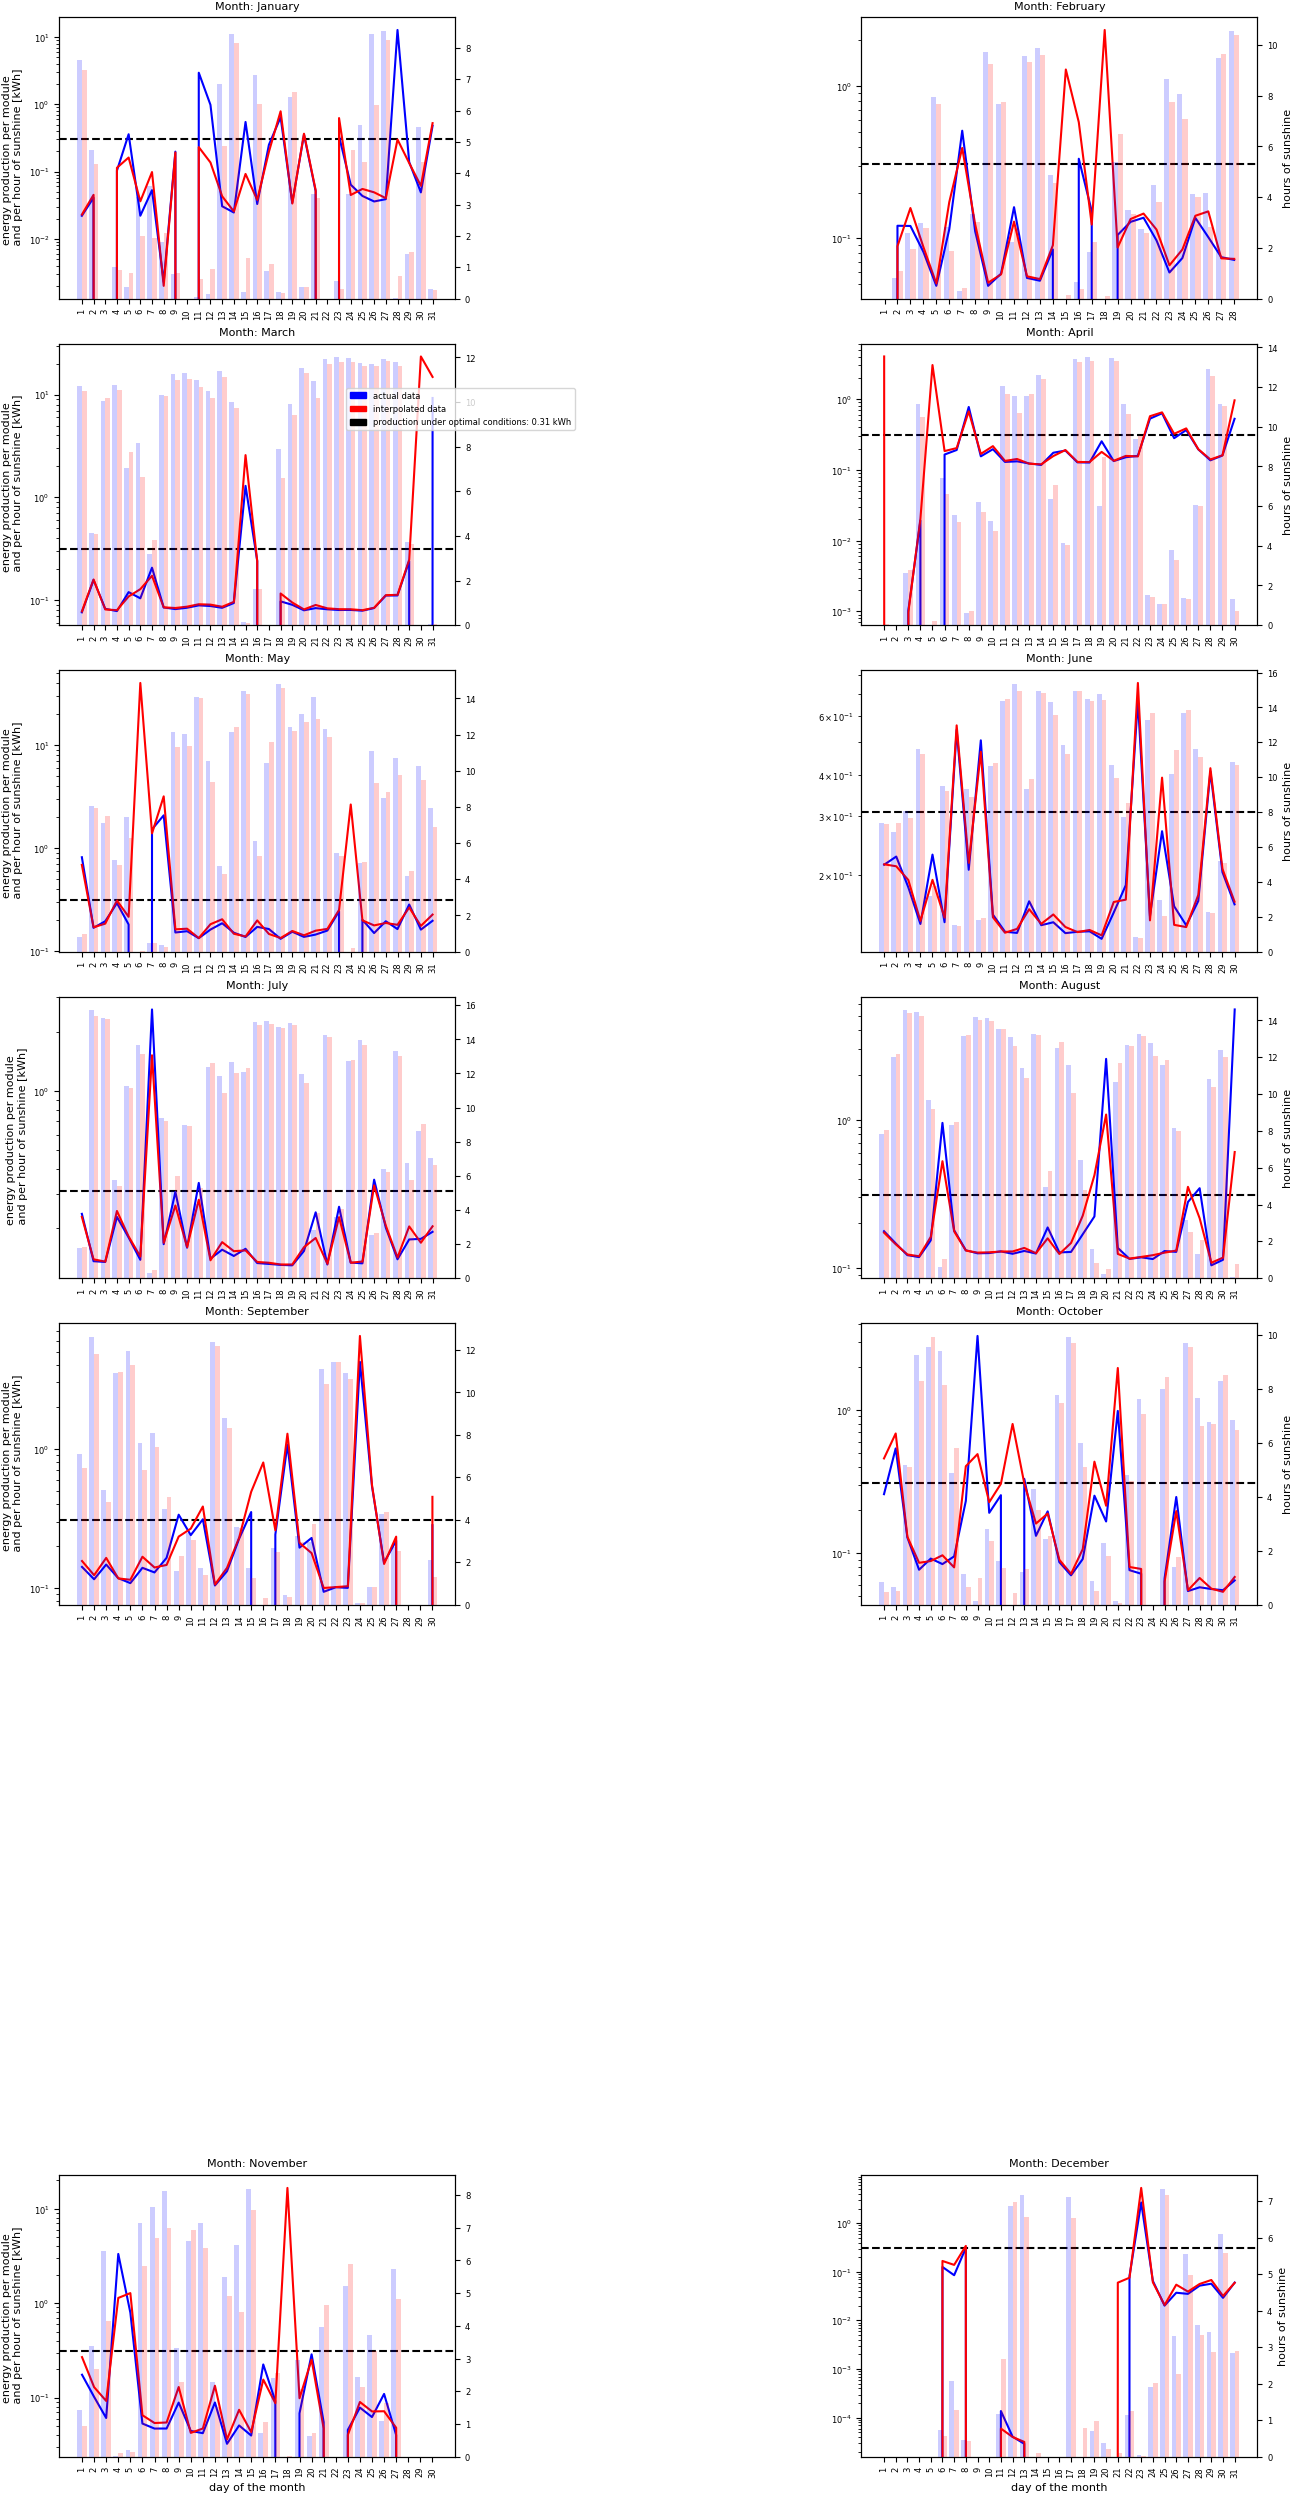

In [32]:
for year in years:
    print(year)
    fig, axes = plt.subplots(6, 2, figsize=(13,25), sharey=False)
    i = 0
    for month in data["Month"].unique():
        ax = axes.flatten()[i]
        # axis for hours of sunshine
        ax2 = ax.twinx()

        month_data = data[(data["Year"] == year) & (data["Month"] == month)]
        month_data_interpolated = data_interpolated[(data_interpolated["Year"] == year) & (data_interpolated["Month"] == month)]
    
        # plot kWh peak
        ax.axhline(0.31, color="black", linestyle="--")
        # plot energy production per sunhour
        ax.plot(
            month_data["Datum und Uhrzeit"],
            month_data["production per hour per module"],
            color="blue"
        )
        # plot energy production per sunhour with interpolated sunhours
        ax.plot(
            month_data_interpolated["Datum und Uhrzeit"],
            month_data_interpolated["production per hour per module"],
            color="red"
        )
        # plot hours of sunshine
        ax2.bar(
            np.arange(len(month_data))-0.2,
            month_data["SDK"],
            color="blue",
            alpha=0.2,
            width=0.4)
        # plot interpolated hours of sunshine
        ax2.bar(
            np.arange(len(month_data))+0.2,
            month_data_interpolated["SDK"],
            color="red",
            alpha=0.2,
            width=0.4)

        ax.set_yscale("log", base=10)
        ax.set_title("Month: " + months[month-1])
        ax.set_xticklabels(np.arange(len(month_data))+1, rotation=90)
        #ax.set_ylim(0,0.5)
        if i in [0, 2, 4, 6, 8, 10]:
            ax.set_ylabel("energy production per module \n and per hour of sunshine [kWh]")
        else:
            ax2.set_ylabel("hours of sunshine")
        i += 1
    
    axes[5,0].set_xlabel("day of the month")
    axes[5,1].set_xlabel("day of the month")
    # legend
    colors = {'actual data': 'blue', 'interpolated data': 'red', "production under optimal conditions: 0.31 kWh": "black"}
    patch = [mpatches.Patch(color=color, label=label) for (label,color) in colors.items()]
    plt.legend(handles=patch, loc=(-1.3,7.2))
    plt.show()

Interpolating the sunshine hours did not solve the problem. Some of the peaks are removed or reduced, some stay the same, but the interpolation also introduced some additional peaks. Is the weather data still not accurate enough or could there be some other explanation (e.g. production under cloudy conditions)?

### Have a closer look at the outlier days (here: for the interpolated data)

### Hours of sunshine

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


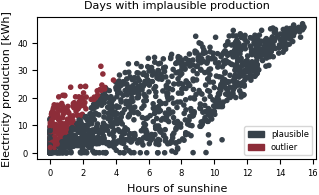

In [47]:
# set plotting stylesheet
plt.rcParams.update(bundles.icml2022(column='half', nrows=1, ncols=1, usetex=False))

fig, ax = plt.subplots(1, 1,sharey=False)
color_data = []
for entry in data_interpolated["production per hour per module"]:
    if((entry > 0.31) ):
        color_data.append(rgb.tue_red)
    else:
        color_data.append(rgb.tue_dark)
ax.scatter(x=data_interpolated["SDK"], y=data_interpolated["Gesamtanlage[kWh]"], c=color_data, marker='.')
    
# legend
colors = {'plausible': rgb.tue_dark, 'outlier': rgb.tue_red}
patch = [mpatches.Patch(color=color, label=label) for (label, color) in colors.items()]
ax.legend(handles=patch, loc='lower right')

ax.set_ylabel(config.labels.production)
ax.set_xlabel(config.labels.sunshine_label)

plt.title('Days with implausible production')
plt.savefig('../report/fig/outlier_scatter.pdf')
plt.show()

Outlier days occur when there are few hours of sunshine (and kind of normal production). Total energy production does not seem strange and outstanding.

#### Cloudiness 
Dsicrete variable from 0 (no clouds) to 8 (maximum clouds).

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


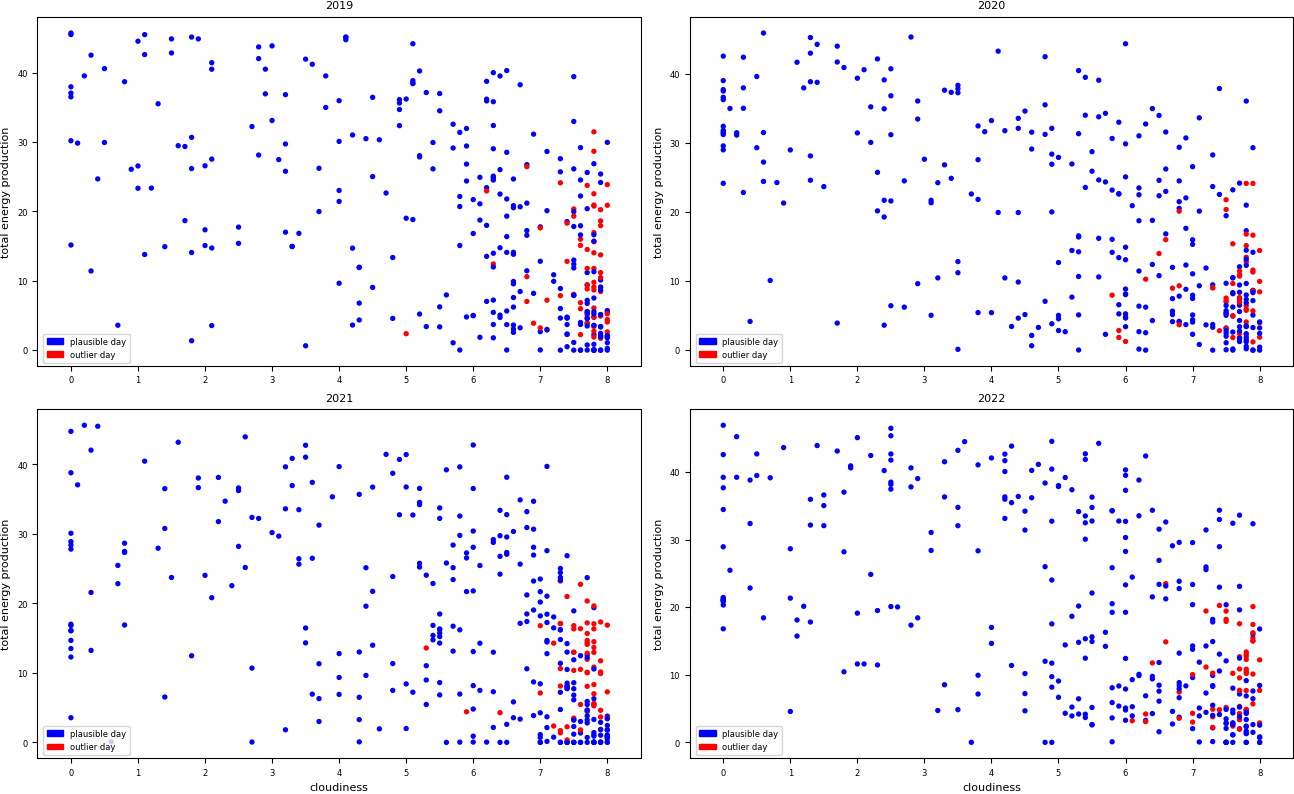

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(13,8), sharey=False)
i = 0
for year in years:
    ax = axes.flatten()[i]
    year_data = data_interpolated[data_interpolated["Year"]==year]
    color_data = np.where(year_data["production per hour per module"]>=0.31, 'red', 'blue')
    ax.scatter(x=year_data["NM"], y=year_data["Gesamtanlage[kWh]"], c=color_data, s=8)
    
    # legend
    colors = {'plausible day': 'blue', 'outlier day': 'red'}
    patch = [mpatches.Patch(color=color, label=label) for (label, color) in colors.items()]
    ax.legend(handles=patch, loc=(0.01, 0.01))

    ax.set_xlim(-0.5,8.5)
    ax.set_ylabel("total energy production")
    ax.set_xlabel("cloudiness")
    ax.set_title(year)
    
    i += 1

axes[0,0].set_xlabel("")
axes[0,1].set_xlabel("")

plt.show()

In [ ]:
print("Median cloudiness of the outlier days (without missing value): " + \
      str(np.round(np.median(outlier_days_interpolated[outlier_days_interpolated["NM"] > -999]["NM"]), 2)))
print("Mean hours of sunshine of the outlier days: " + str(np.round(outlier_days_interpolated["SDK"].mean(), 2)))
print("Max hours of sunshine of the outlier days: " + str(np.round(outlier_days_interpolated["SDK"].max(), 2)))
print("Mean production of the outlier days: " + str(np.round(outlier_days_interpolated["Gesamtanlage[kWh]"].mean(), 2)) + "kWh")

Median cloudiness of the outlier days (without missing value): 7.7
Mean hours of sunshine of the outlier days: 0.79
Max hours of sunshine of the outlier days: 3.86
Mean production of the outlier days: 10.56kWh


There are missing values (cloudiness = -1000). However, this does not seem to affect the outlier days, since there are outlier days and plausible days among the days with missing values. Consistent with the observation that outlier days occur on days with few hours of sunshine, it can be seen here that there is a high degree of cloud cover on all of these days. We now want to see if the energy produced can be explained by cloud production. We can assume that a fraction of the maximum production can be produced during the day, even if the sun is covered by clouds. Perhaps this is enough to explain the unrealistic production peaks. 

In [ ]:
# to estimate the production without direct sun, we need the hours of daytime for each day
def get_daylight_hours(year, month, day):
    lat, lon = 48.174597740503394, 11.236288062447413 # From Google Maps, for Fuerstenfeldbruck
    date = datetime.datetime(year, month, day)

    time_delta = get_times(date, lon, lat)["sunset"] - get_times(date, lon, lat)["sunrise"]
    return int(np.round(time_delta / datetime.timedelta(hours=1), 0))

Interpolated data:

In [ ]:
# estimated fraction of efficiency during cloud cover
cloud_efficiency = 0.055
daylight_hours = []
# get daylight hours
for idx in outlier_days_interpolated.index:
    day = int(outlier_days_interpolated.loc[idx]["Datum und Uhrzeit"][0:2])
    month = outlier_days_interpolated.loc[idx]["Month"]
    year = outlier_days_interpolated.loc[idx]["Year"]
    daylight_hours.append(get_daylight_hours(year, month, day))
daylight_hours = np.array(daylight_hours)
# estimate cloud production
cloud_production = kWhp_system * daylight_hours * cloud_efficiency
rest_production = outlier_days_interpolated["Gesamtanlage[kWh]"] - cloud_production
outlier_days_interpolated["rest production per hour per module"] = rest_production / outlier_days_interpolated["SDK"] / 22

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


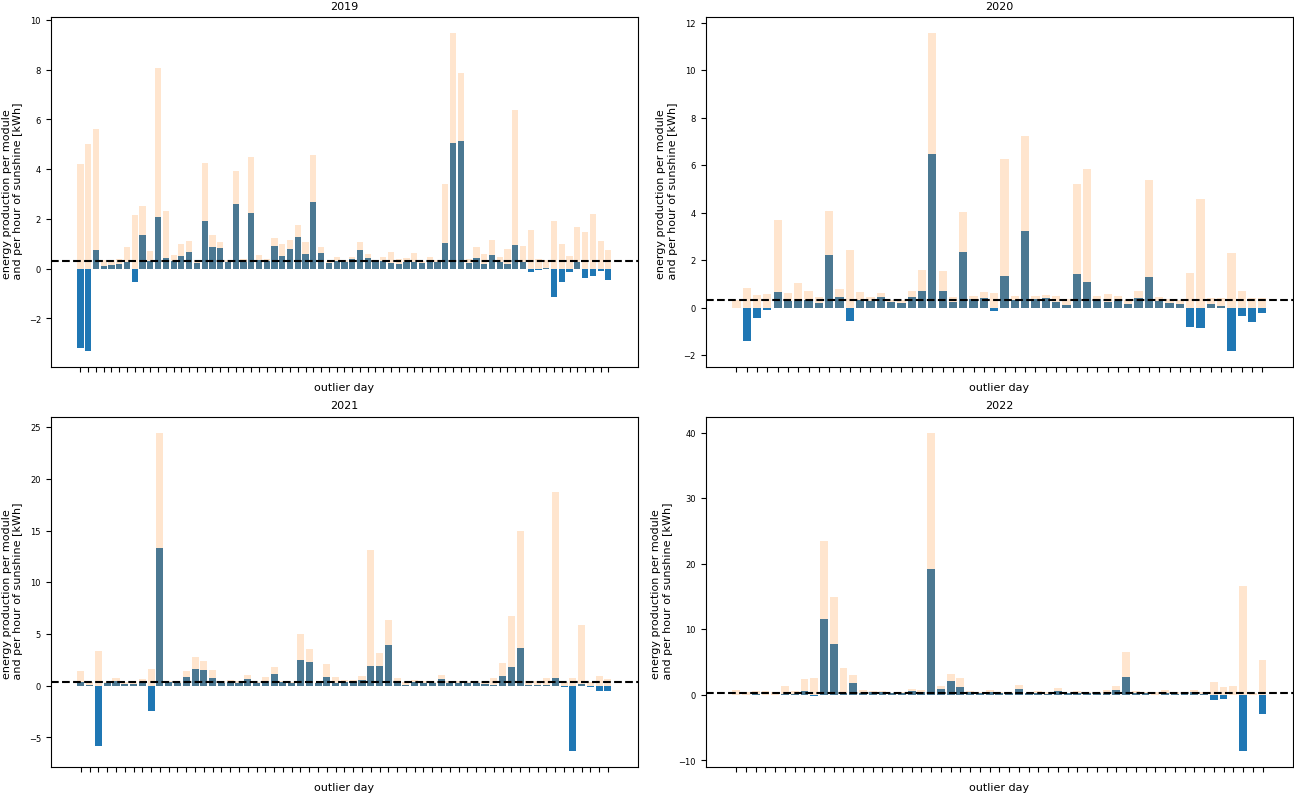

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(13,8), sharey=False)
i = 0
for year in years:
    ax = axes.flatten()[i]
    year_data = outlier_days_interpolated[outlier_days_interpolated["Year"]==year]
    # plot kWh peak
    ax.axhline(0.31, color="black", linestyle="--")
    ax.bar(year_data["Datum und Uhrzeit"], year_data["rest production per hour per module"])
    ax.bar(year_data["Datum und Uhrzeit"], year_data["production per hour per module"], alpha=0.2)
    #ax.set_ylim(-0.5, 0.5)
    ax.set_xticklabels("")
    ax.set_title(year)
    ax.set_ylabel("energy production per module \n and per hour of sunshine [kWh]")
    ax.set_xlabel("outlier day")
    i+=1

In [ ]:
print("Total number of outlier days: " + str(len(outlier_days_interpolated)))
print("Number of outlier days explained with cloud production: " \
      + str(((outlier_days_interpolated["rest production per hour per module"] <= 0.31) & \
             (outlier_days_interpolated["rest production per hour per module"] >= 0)).sum()))
print("Number of outlier days with too much cloud production: " \
     + str((outlier_days_interpolated["rest production per hour per module"] < 0).sum()))
print("Number of outlier days with still too much production per hour: " \
     + str((outlier_days_interpolated["rest production per hour per module"] > 0.31).sum()))

Total number of outlier days: 237
Number of outlier days explained with cloud production: 90
Number of outlier days with too much cloud production: 41
Number of outlier days with still too much production per hour: 106


Some of the production peaks can be explained by cloud production. However, on some days (or maybe in general) we overestimated the cloud production, resulting in a higher estimate than what was actually produced. The observed peaks are probably caused by both inaccurate weather data and neglect of cloud production. However, the results also show that the energy production cannot be explained by the sun or cloud cover alone, but is probably a mixture of different components. Therefore, a more complex analysis is required.

In [ ]:
print("Is snow the reason why there is less cloud production than estimated?")
outlier_days_interpolated[outlier_days_interpolated["rest production per hour per module"] < 0]["SHK_TAG"]

Is snow the reason why there is less cloud production than estimated?


0         0
22        3
41        0
306       0
308       0
320       0
323       0
324       0
345       0
350       0
356       0
358       0
369       0
371       0
372       0
382       0
434       0
523    -999
664       0
667       0
697       0
705       0
711       0
721       0
764       0
810       0
1061      0
1062      0
1080      0
1089      0
1092      0
1113      0
1115      1
1126      0
1133      0
1169      0
1389      0
1403      0
1417      0
1437      0
1452      0
Name: SHK_TAG, dtype: int64

There are only 2 days with snow reported and one day where this features is missing.

Original weather data:

In [ ]:
cloud_efficiency = 0.05
daylight_hours = []
# get daylight hours
for idx in outlier_days.index:
    day = int(outlier_days.loc[idx]["Datum und Uhrzeit"][0:2])
    month = outlier_days.loc[idx]["Month"]
    year = outlier_days.loc[idx]["Year"]
    daylight_hours.append(get_daylight_hours(year, month, day))
daylight_hours = np.array(daylight_hours)
# estimate cloud production
cloud_production = kWhp_system * daylight_hours * cloud_efficiency
rest_production = outlier_days["Gesamtanlage[kWh]"] - cloud_production
outlier_days["rest production per hour per module"] = rest_production / outlier_days["SDK"] / 22

findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times
findfont: Generic family 'serif' not found because none of the following families were found: Times


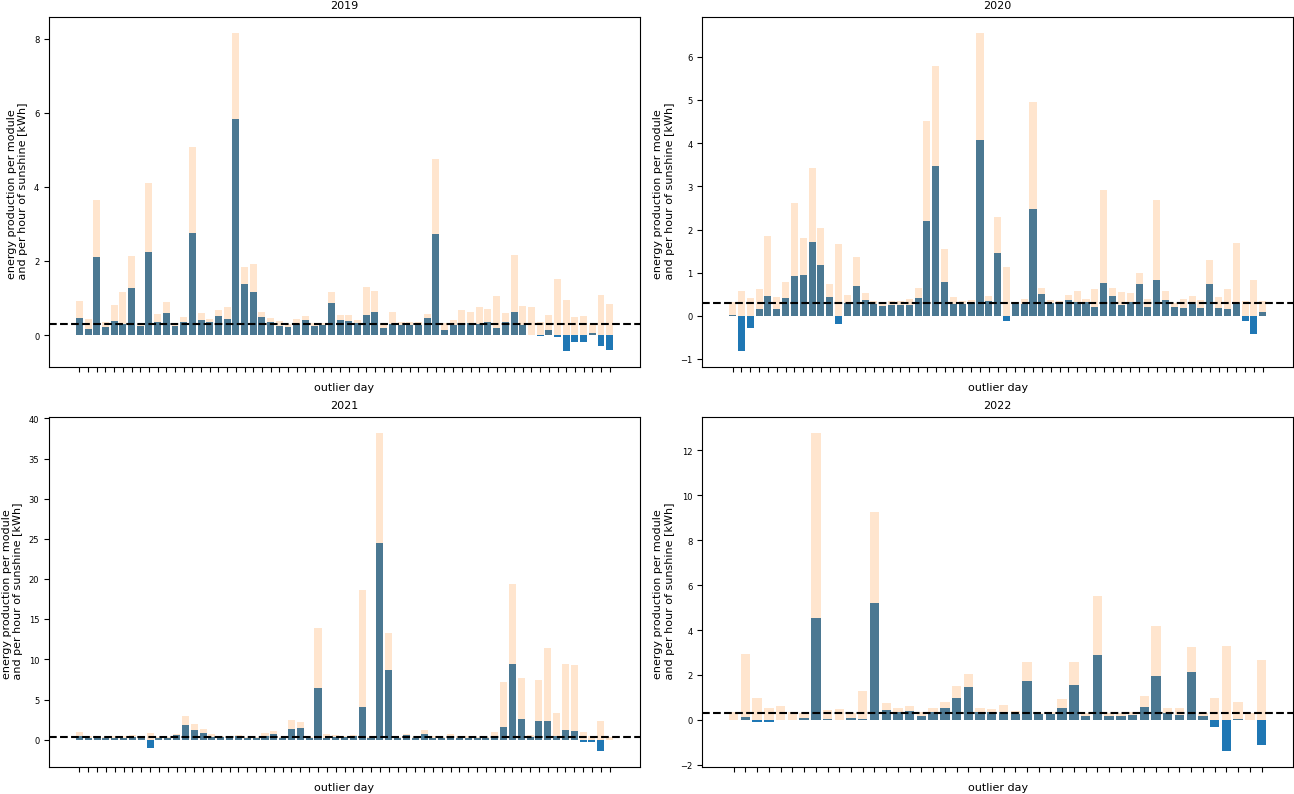

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(13,8), sharey=False)
i = 0
for year in years:
    ax = axes.flatten()[i]
    year_data = outlier_days[outlier_days["Year"]==year]
    # plot kWh peak
    ax.axhline(0.31, color="black", linestyle="--")
    ax.bar(year_data["Datum und Uhrzeit"], year_data["rest production per hour per module"])
    ax.bar(year_data["Datum und Uhrzeit"], year_data["production per hour per module"], alpha=0.2)
    #ax.set_ylim(-0.5, 0.5)
    ax.set_xticklabels("")
    ax.set_title(year)
    ax.set_ylabel("energy production per module \n and per hour of sunshine [kWh]")
    ax.set_xlabel("outlier day")
    #ax.set_yscale('log',base=10) 
    i+=1
plt.show()

In [ ]:
print("Total number of outlier days: " + str(len(outlier_days)))
print("Number of outlier days explained with cloud production: " \
      + str(((outlier_days["rest production per hour per module"] < 0.31) & \
             (outlier_days["rest production per hour per module"] >= 0)).sum()))
print("Number of outlier days with too much cloud production: " \
     + str((outlier_days["rest production per hour per module"] < 0).sum()))
print("Number of outlier days with still too much production per hour: " \
     + str((outlier_days["rest production per hour per module"] >= 0.31).sum()))

Total number of outlier days: 230
Number of outlier days explained with cloud production: 91
Number of outlier days with too much cloud production: 24
Number of outlier days with still too much production per hour: 115


In [ ]:
print("Is snow the reason why there is less cloud production than estimated?")
outlier_days[outlier_days["rest production per hour per module"] < 0]["SHK_TAG"]

Is snow the reason why there is less cloud production than estimated?


308       0
314       0
320       0
323       0
330       0
332       0
358       0
371       0
372       0
434       0
523    -999
705       0
721       0
810       0
1080      0
1089      0
1092      0
1107      0
1110      0
1113      0
1115      1
1389      0
1403      0
1452      0
Name: SHK_TAG, dtype: int64

There is only one day with snow reported and one day where this features is missing.